In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from pathlib import Path
from glob import glob
import os

In [2]:
model1 = keras.models.load_model("model_56px_neuralnet_128_64_64_128_kernel3x3")
model2 = keras.models.load_model("model_128px_neuralnet_128_64_64_128_kernel3x3")
model3 = keras.models.load_model("model_dset2_56px_neuralnet_vanilla")
model4 = keras.models.load_model("model_ds2_56px_neuralnet_128_64_64_128_kernel3x3")

In [25]:
class Denoiser():
    """ Works on PIL <Image> objects.
    Denoiser.denoise() returns a denoised image, based on the model and
    input parameters.
    
    params
    ======
    
    image: an open PIL Image object
    model: a keras trained model object
    
    tile_size: <int> lenght, in pixel, of the square being denoised
        by the model. Higher values use higher amounts of RAM.
    
    """
    
    def __init__(self, image, model,
                 tile_size, # <int> or (horizontal pixels, vertical pixels)
                 debug=False, verbose=True
    ):
        self.image = image
        self.model = model
        
        if isinstance(tile_size, tuple):
            assert len(tile_size) == 2
            self.tile_size_h, self.tile_size_v = tile_size
            assert isinstance(self.tile_size_h, (int, float))
            assert isinstance(self.tile_size_v, (int, float))
        elif isinstance(tile_size, (int, float)):
            self.tile_size_h = tile_size
            self.tile_size_v = tile_size
        else:
            raise TypeError("tile_size expected as <int> or 2-elems <tuple>")
        
        # in case floats were passed
        self.tile_size_h = int(self.tile_size_h)
        self.tile_size_v = int(self.tile_size_v)
        
        assert isinstance(debug, bool)
        assert isinstance(verbose, bool)
        
        self.debug = debug
        self.verbose = verbose
        

    def _deb(self, *args, **kwargs):
        if self.debug:
            print(*args,**kwargs)

            
    def _say(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)


    # from Dataset class, *adapted* to be asymmetric
    def _crop_in_tiles(self, image, shift=0, asarray=True):

        """
        This generator function crops an image in several tiles
        tile_size × tile_size squares, yielding a tile
        every iteration.

        If the input image is not a perfect multiple of
        a(tile_size) × b(tile_size), non-square tiles are NOT
        YIELDED.

        params
        ======

        image: a Pillow open image
        tile_size: <int> pixels; size of the tile side
        shift: <int>: the offset from 0,0 in pixels
        
        yields
        ======
        
        A tile_size × tile_size np.array taken form the input image,
        but converted to float32 type and with values normalized from
        0 to 1
        """

        assert isinstance(shift, int)
        
        width, height = image.size

        #calculate coordinates of every tile
        for x in range (0 + shift, width, self.tile_size_h):
            if width - x < self.tile_size_h:
                continue

            for y in range (0 + shift, height, self.tile_size_v):
                if height - y < self.tile_size_v:
                    continue

                # tile coord ===
                tile_coord = (
                    x, y, # upper left coords
                    x + self.tile_size_h, y + self.tile_size_v # lower right coords
                )

                tile = image.crop(tile_coord)

                if not asarray:
                    yield tile #yielding tile as image
                else:
                    yield np.array(tile).astype("float32") / 255
        
        
    def _predict_tiles_from_image(self, image, model):
        """ This gives back the denoised <tiles>, according to the loaded <model>
        The model operates on multiple tiles at once. All tiles are shaped into a form
        that the model was trained for, then all put into a np.array container.
        This is the way the models expects the tiles for the prediction.

        NOTE: This function relies on crop_in_tiles() function.

        params
        ======

        image: a pillow Image object
        model: a keras trained model
        
        tile_size: <int> pixels. The model will operate and predict on a square with
            <tile_size> side. Higher values allocate higher amounts of RAM.
            
        returns
        ======
        
        A np.array containing all denoised (predicted) tiles
        """
                
        to_predict = [
            x.reshape(self.tile_size_v, self.tile_size_h, 1) for x in self._crop_in_tiles(image)
        ]

        # the model expects an array of tiles, not a list of tiles
        to_predict = np.array(to_predict)

        return model.predict(to_predict)

    
    def _image_rebuilder(self, image, model):
        """ Takes as input a monochromatic (single-channel) image,
        returns a denoised monochromatic image.
        
        params
        ======
        
        image: a PIL monochromatic image. ONLY ONE channel is supported
        model: a trained keras model to denoise the input image
        
        tile_size: <int> pixels of a square side to process at once.
            This is not related to the tile_size the model has been built
            with, but dictates how big is the square the model is fed with
            for denoising. The bigger this parameter, the more RAM is needed
            to perform the denoising.
            This cannot be higher than the image phisical size.
            
        returns
        =======
        A monochromatic, denoised PIL.Image object
        
        """

        # I was initially wondering to manage the channel splitting here,
        # but as the model is currently working on monochromatic images,
        # and will eventually manage the three channels with three different
        # models (again, with one channel per image), this stub of implementation
        # is not necessary anymore.
        # TODO: clear the clutter
        channels = [image]

        width, height = channels[0].size #all three channels have the same size
        self._say(f"width: {width}; height: {height}")

        # TODO
        # for now, we support only exact multiples of tile_size
        tile_width = int(width / self.tile_size_h)
        tile_height = int(height / self.tile_size_v)

        self._say(f"Image multiple of {tile_width}×{tile_height} integer tiles.")

        for i, channel in enumerate(channels):
            
            # next line useless if we just process one channel
            #self._say(f"Processing channel {i + 1} of {len(channels)}")            
            pred_tiles = [self._predict_tiles_from_image(channel, model)]

            self._deb(f"Predicted tiles length: {len(pred_tiles[0])}")

            # now we need to rebuild a numpy array based on the tile_width*tile_height original geometry        
            gen = (x for x in pred_tiles[0])

            # the final assembly is very fast ===
            returnimage = []

            #for i in range(tile_height):
            #    row_tiles = next(gen)
            #    for j in range(tile_width - 1):
            #        next_tile = next(gen)
            #        row_tiles = np.concatenate((row_tiles, next_tile), axis=1)
            #    returnimage.append(row_tiles)
            #
            #returnimage = np.array(returnimage)
            #returnimage = np.vstack(returnimage)

            for i in range(tile_width):
                row_tiles = next(gen)
                for j in range(tile_height - 1):
                    next_tile = next(gen)
                    row_tiles = np.concatenate((row_tiles, next_tile), axis=0)
                returnimage.append(row_tiles)

            returnimage = np.array(returnimage)
            returnimage = np.hstack(returnimage)

            # from array (0-1) to Image (0-255)
            returnimage = np.uint8(returnimage * 255)
            
            # discarding the last dimension
            return Image.fromarray(returnimage[:,:,0])   

        
    def denoise(self):
        
        self._say("Denoising red channel..")
        denoised_r = self._image_rebuilder(
            self.image.getchannel("R"), self.model
        )
        
        self._say("Denoising green channel..")
        denoised_g = self._image_rebuilder(
            self.image.getchannel("G"), self.model
        )
        
        self._say("Denoising blue channel..")
        denoised_b = self._image_rebuilder(
            self.image.getchannel("B"), self.model
        )
        
        rgb = Image.merge("RGB",(denoised_r, denoised_g, denoised_b))
        
        
        self.denoised_ = rgb
        del denoised_r, denoised_g, denoised_b
        self._say("Denoised image in 'denoised_' attribute.")
        
        return rgb

In [31]:
img = Image.open("sample_320x200.png")

In [38]:
d = Denoiser(img, model4, tile_size=(320/4,200/4))

Denoising red channel..
width: 320; height: 200
Image multiple of 4×4 integer tiles.
Denoising green channel..
width: 320; height: 200
Image multiple of 4×4 integer tiles.
Denoising blue channel..
width: 320; height: 200
Image multiple of 4×4 integer tiles.
Denoised image in 'denoised_' attribute.


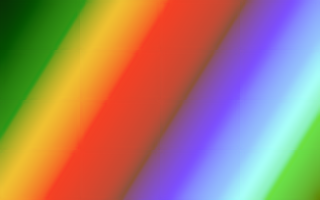

In [39]:
d.denoise()